In [1]:
# Dataset information: https://bbci.de/competition/iv/desc_1.html
# This Dataset is the downsampled version at 100Hz

In [2]:
import numpy as np
from scipy.io import loadmat
import matplotlib.pyplot as plt 
import scipy
import sklearn

In [3]:
# Load the MATLAB file 
EEG_data = loadmat('/home/costanza/thesis/Datasets/BCI_Competition_IV/calib/BCICIV_1_mat/BCICIV_calib_ds1a.mat', struct_as_record = True)

# List all the keys in the loaded data
keys = EEG_data.keys()

# Print the keys variables to identify the correct key for EEG data
print(keys)

dict_keys(['__header__', '__version__', '__globals__', 'mrk', 'cnt', 'nfo'])


In [4]:
# Extract data
markers = EEG_data['mrk']
s_freq = EEG_data['nfo']['fs'][0][0][0][0]
EEGdata   = EEG_data['cnt'].T 
n_channels, n_samples = EEGdata.shape

time_unit = 1 / s_freq
print("Time Unit:", time_unit, "seconds")

chan_names = [s[0] for s in EEG_data['nfo']['clab'][0][0][0]]

event_onsets  = EEG_data['mrk'][0][0][0] # Time points when events occurred
event_codes   = EEG_data['mrk'][0][0][1] # It contains numerical or categorical labels associated with each event.
event_onset_time = event_onsets * time_unit # Seconds

# Creates an array of zeros and then assigns the event codes to the corresponding positions based on the event onsets.
labels = np.zeros((1, n_samples), int)
labels[0, event_onsets] = event_codes

cl_lab = [s[0] for s in EEG_data['nfo']['classes'][0][0][0]]
cl1    = cl_lab[0]
cl2    = cl_lab[1]

# digitized electrode positions 
xpos = EEG_data['nfo']['xpos']
ypos = EEG_data['nfo']['ypos']

n_classes = len(cl_lab)
n_events = len(event_onsets)

# Print some information
print('Shape of EEG:', EEGdata.shape)
print('Sample rate:', s_freq)
print('Number of channels:', n_channels)
print('Channel names:', chan_names)
print('Number of events (MI movements):', event_onsets.shape[1])
print('Event codes:', np.unique(event_codes))
print('Class labels:', cl_lab)
print('Number of classes:', n_classes)
print(EEGdata[0,:50])
print(event_codes)
print(event_onsets)


Time Unit: 0.01 seconds
Shape of EEG: (59, 190594)
Sample rate: 100
Number of channels: 59
Channel names: ['AF3', 'AF4', 'F5', 'F3', 'F1', 'Fz', 'F2', 'F4', 'F6', 'FC5', 'FC3', 'FC1', 'FCz', 'FC2', 'FC4', 'FC6', 'CFC7', 'CFC5', 'CFC3', 'CFC1', 'CFC2', 'CFC4', 'CFC6', 'CFC8', 'T7', 'C5', 'C3', 'C1', 'Cz', 'C2', 'C4', 'C6', 'T8', 'CCP7', 'CCP5', 'CCP3', 'CCP1', 'CCP2', 'CCP4', 'CCP6', 'CCP8', 'CP5', 'CP3', 'CP1', 'CPz', 'CP2', 'CP4', 'CP6', 'P5', 'P3', 'P1', 'Pz', 'P2', 'P4', 'P6', 'PO1', 'PO2', 'O1', 'O2']
Number of events (MI movements): 200
Event codes: [-1  1]
Class labels: ['left', 'foot']
Number of classes: 2
[ -3 -25 -34  24  44  30  74 105 105  89  52  17  33  84  20 -31  42  29
  -6  -6  -2  35  96 178 158  85  47  50  91 128 150 140 135 159 163 137
  60   5  11 -10 -18 -12   0  30  21 -29   6  96 148 220]
[[ 1  1 -1  1  1  1  1 -1 -1  1 -1  1 -1 -1 -1  1 -1 -1  1 -1  1  1 -1 -1
  -1 -1 -1  1 -1 -1 -1 -1 -1 -1 -1 -1 -1  1  1  1 -1 -1  1 -1  1 -1  1  1
   1  1  1  1  1 -1  1  1  

In [5]:
# Segmentation
# Dictionary to store the trials in, each class gets an entry
trials = {}

# The time window (in samples) to extract for each trial, here 0.5 -- 4.5 seconds
win = np.arange(int(0.5*s_freq), int(4.5*s_freq)) # 400 samples
nsamples_win = len(win)


In [6]:
# Loop over the classes (left, foot)
for cl, code in zip(cl_lab, np.unique(event_codes)):

    # Extract the onsets for the class
    cl_onsets = event_onsets[event_codes == code]
    trials[cl] = np.zeros((len(EEGdata[:,0]), nsamples_win, len(cl_onsets)))

    # Extract each trial
    for i, onset in enumerate (cl_onsets):
        trials[cl][:,:,i] = EEGdata[:,win + onset]


left = np.rollaxis(trials[cl1], 2, 0)  
foot = np.rollaxis(trials[cl2], 2, 0)
data = np.concatenate([left, foot])

In [7]:
from scipy.fftpack import fft

# FFT computation for each trial for selected channels
fft_trials = {}

for cl in cl_lab:
    # Get the segmented data for the current class
    segmented_data = trials[cl]

    # Allocate memory for FFT results
    fft_trials[cl] = np.zeros_like(segmented_data, dtype=complex)

    # Compute FFT for each trial for selected channels
    for i in range(segmented_data.shape[2]):
        # Apply FFT along the second axis (axis=1), which represents the time samples
        fft_trials[cl][:, :, i] = fft(segmented_data[:, :, i], axis=1)

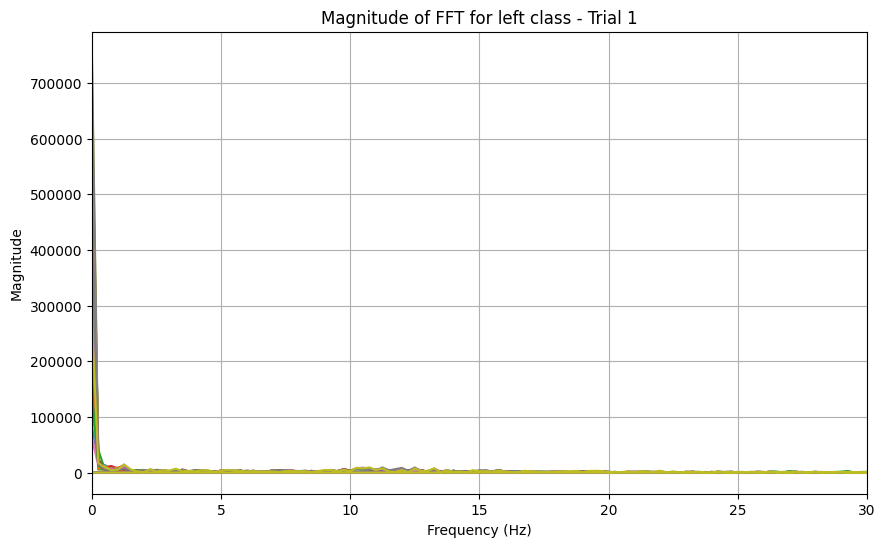

In [8]:
# Choose a specific trial index
trial_index = 0

# Choose a class (left or foot)
selected_class = cl1

# Get the FFT result for the selected trial and class
fft_result = fft_trials[selected_class][:, :, trial_index]

# Extract the frequency values corresponding to the FFT result
freq_values = np.fft.fftfreq(fft_result.shape[1], d=time_unit)

# Compute the magnitude of the FFT
fft_magnitude = np.abs(fft_result)

# Plot the magnitude of the FFT
plt.figure(figsize=(10, 6))
plt.plot(freq_values, fft_magnitude[:, :].T)  # Plot all channels
plt.title(f'Magnitude of FFT for {selected_class} class - Trial {trial_index + 1}')
plt.xlabel('Frequency (Hz)')
plt.ylabel('Magnitude')
plt.xlim(0,30)
plt.grid(True)
plt.show()

In [9]:
# LDA

from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.model_selection import train_test_split
from sklearn.svm import SVC
from sklearn.metrics import accuracy_score, roc_auc_score

In [10]:
print(fft_trials[cl].shape)

(59, 400, 100)


In [11]:
# Calculate the magnitude of the FFT
for cl in fft_trials:
    fft_trials[cl] = np.abs(fft_trials[cl])

# Prepare the data for LDA 
n_trials_cl1 = fft_trials[cl1].shape[2]
n_trials_cl2 = fft_trials[cl2].shape[2]
n_features = fft_trials[cl1].shape[0] * fft_trials[cl1].shape[1]

# Reshape the FFT data: Flatten each trial into a single row
X_cl1 = fft_trials[cl1].reshape(n_trials_cl1, n_features)
X_cl2 = fft_trials[cl2].reshape(n_trials_cl2, n_features)

X = np.concatenate([X_cl1, X_cl2], axis = 0)

# Create labels: 0 for class 1, 1 for class 2
y = np.concatenate([np.zeros(n_trials_cl1), np.ones(n_trials_cl2)])

X_train, X_test, y_train, y_test = train_test_split(X,y,test_size = 0.30, random_state = 42)

lda = LinearDiscriminantAnalysis(n_components = 1)
X_train_lda = lda.fit_transform(X_train,y_train)

X_test_lda = lda.transform(X_test)

print('Shape of X and y:', X.shape, y.shape)
print('Shape of data after LDA: ', X_train_lda.shape, X_test_lda.shape)

Shape of X and y: (200, 23600) (200,)
Shape of data after LDA:  (140, 1) (60, 1)


In [12]:
# SVM

from sklearn.metrics import precision_score, recall_score, f1_score

svm = SVC(probability=True)
svm.fit(X_train_lda, y_train)

y_pred = svm.predict(X_test_lda) # Predict the class labels for the test data
y_pred_proba = svm.predict_proba(X_test_lda)[:,1] # Proba returns an array where the first column represents the probability of the negative class, and the second column represents the probability of the positive class

accuracy_svm = accuracy_score(y_test, y_pred)
auc_svm = roc_auc_score(y_test, y_pred_proba)
print('Accuracy:', accuracy_svm)
print('AUC:',auc_svm)

Accuracy: 0.7833333333333333
AUC: 0.9599555061179088


In [13]:
from sklearn.neighbors import KNeighborsClassifier

# Initialize KNN classifier
knn = KNeighborsClassifier(n_neighbors=9)  
# Train the classifier
knn.fit(X_train_lda, y_train)

# Make predictions on the test set
y_pred_knn = knn.predict(X_test_lda)
y_pred_proba_knn = knn.predict_proba(X_test_lda)[:, 1]
# Evaluate the accuracy and the AUC
accuracy_knn = accuracy_score(y_test, y_pred_knn)
auc_knn = roc_auc_score(y_test, y_pred_proba_knn)
print('Accuracy of KNN:', accuracy_knn)
print('AUC of KNN:',auc_knn)

Accuracy of KNN: 0.7333333333333333
AUC of KNN: 0.8459399332591769


In [14]:
from sklearn.naive_bayes import GaussianNB

# Initialize Gaussian Naive Bayes classifier
nb_classifier = GaussianNB()

# Train the classifier
nb_classifier.fit(X_train_lda, y_train)

# Make predictions on the test set
y_pred_nb = nb_classifier.predict(X_test_lda)

# Evaluate the accuracy and the AUC
accuracy_nb = accuracy_score(y_test, y_pred_nb)
print('Accuracy of NB:', accuracy_nb)

# Calculate and print the AUC
# Use predicted probabilities for class 1
proba_class_1_nb = nb_classifier.predict_proba(X_test_lda)[:, 1]
auc_nb = roc_auc_score(y_test, proba_class_1_nb)
print(f'AUC of Gaussian Naive Bayes: {auc_nb:.4f}')

Accuracy of NB: 0.9333333333333333
AUC of Gaussian Naive Bayes: 0.9422


In [15]:
# Classification using Logistic Regression
from sklearn.linear_model import LogisticRegression

# Initialize Logistic Regression classifier
logreg_classifier = LogisticRegression()

# Train the classifier
logreg_classifier.fit(X_train_lda, y_train)

# Make predictions on the test set
y_pred_lr = logreg_classifier.predict(X_test_lda)

# Evaluate the accuracy
acc_lr = accuracy_score(y_test, y_pred_lr)
print('Accuracy of Logistic Regression:', acc_lr)

# Calculate and print the AUC
# Use predicted probabilities for class 1
proba_class_1_lr = logreg_classifier.predict_proba(X_test_lda)[:, 1]
auc_lr = roc_auc_score(y_test, proba_class_1_lr)
print('AUC of Logistic Regression:', auc_lr)


Accuracy of Logistic Regression: 0.9333333333333333
AUC of Logistic Regression: 0.9432703003337042


In [16]:
# Classification using Decision Tree
from sklearn.tree import DecisionTreeClassifier


# Initialize Decision Tree classifier
dt_classifier = DecisionTreeClassifier()

# Train the classifier
dt_classifier.fit(X_train_lda, y_train)

# Make predictions on the test set
y_pred_dt = dt_classifier.predict(X_test_lda)

# Evaluate the accuracy
acc_dt = accuracy_score(y_test, y_pred_dt)
print('Accuracy of Logistic Regression:', acc_dt)

# Calculate and print the AUC
# Use predicted probabilities for class 1
proba_class_1_dt = logreg_classifier.predict_proba(X_test_lda)[:, 1]
auc_dt = roc_auc_score(y_test, proba_class_1_dt)
print('AUC of Logistic Regression:', auc_dt)

Accuracy of Logistic Regression: 0.8166666666666667
AUC of Logistic Regression: 0.9432703003337042


In [17]:
# Initialize classifiers
classifiers = {
    'KNN': KNeighborsClassifier(n_neighbors=3),
    'NB': GaussianNB(),
    'LR': LogisticRegression(),
    'DT': DecisionTreeClassifier(),
    'SVM': SVC(probability=True),  # Use probability=True for SVM to enable predict_proba
}

# Create a NumPy array to store the results
results_array = np.empty((len(classifiers), 2), dtype=float)

# Iterate over classifiers and fill the array
for i, (clf_name, clf) in enumerate(classifiers.items()):
    # Train the classifier
    clf.fit(X_train_lda, y_train)

    # Make predictions on the test set
    y_pred = clf.predict(X_test_lda)

    # Calculate accuracy
    accuracy = accuracy_score(y_test, y_pred)

    # Calculate AUC
    if hasattr(clf, 'predict_proba'):
        proba_class_1 = clf.predict_proba(X_test_lda)[:, 1]
    else:  # For SVM, use decision_function
        proba_class_1 = clf.decision_function(X_test_lda)
    auc = roc_auc_score(y_test, proba_class_1)

    # Store results in the array
    results_array[i, 0] = accuracy
    results_array[i, 1] = auc

# Print the results array
print("Classifier\tAccuracy\tAUC")
for i, (clf_name, _) in enumerate(classifiers.items()):
    print(f"{clf_name}\t\t{results_array[i, 0]:.4f}\t\t{results_array[i, 1]:.4f}")

Classifier	Accuracy	AUC
KNN		0.7000		0.7976
NB		0.9333		0.9422
LR		0.9333		0.9433
DT		0.8167		0.8170
SVM		0.7833		0.9600


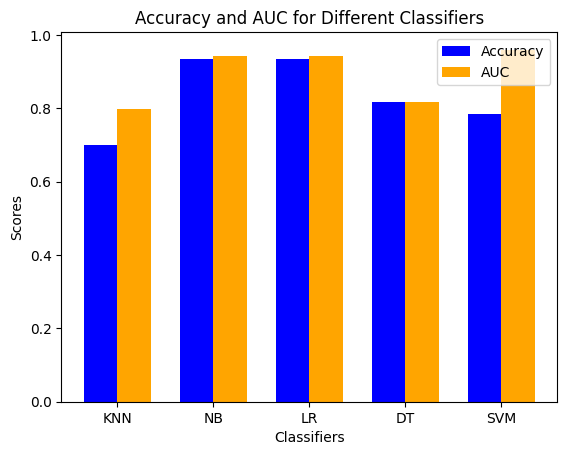

In [18]:
# Grafico a barre

# Plotting the bar chart
bar_width = 0.35
index = np.arange(len(classifiers))

fig, ax = plt.subplots()
bar1 = ax.bar(index, results_array[:, 0], bar_width, label='Accuracy', color='blue')
bar2 = ax.bar(index + bar_width, results_array[:, 1], bar_width, label='AUC', color='orange')

ax.set_xlabel('Classifiers')
ax.set_ylabel('Scores')
ax.set_title('Accuracy and AUC for Different Classifiers')
ax.set_xticks(index + bar_width / 2)
ax.set_xticklabels(classifiers.keys())
ax.legend()

plt.show()
